# Generating Baseline HASPI Scores

The Clarity Enhancement Challenge 2 (CEC2) comes with a simple baseline system against which you can compare your own system's performance. 

The baseline system has two stages:

- **NALR amplification**: Hearing aid amplification using a listener's audiogram and the NALR prescription. 
- **A compressor**: An automatic gain control (AGC) and compression stage that will output to 16 bit audio without clipping. 
  
Note, this is a very simple baseline designed to act as a starting point, e.g., there is no explicit noise-cancellation front end. 

Once signals have been processed by the baseline system they can be evaluated using the standard HASPI metric. 

Recipes (i.e. Python scripts) are provided to allow you to easily process and evaluate the complete development set. These receipes have commandline interfaces and can be found at,

```
clarity/recipes/cec2/baseline/enhance.py
clarity/recipes/cec2/baseline/evaluate.py
```

This tutorial will walk through the steps being performed in these recipes. We will be using a demo data subset of the full Clarity data, and loading and calling the modules that are invoked in the recipe scripts.

### Install dependencies

We first need to install the Clarity package.

In [1]:
print("Cloning git repo...")

!git clone --quiet https://github.com/claritychallenge/clarity.git
%cd clarity
%pip install -e .
import os
import sys

sys.path.append(os.getcwd())
%cd ..

Cloning git repo...
/home/gerardoroadabike/Extended/Projects/clarity/notebooks/clarity


/home/gerardoroadabike/anaconda3/envs/clarity39/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Obtaining file:///home/gerardoroadabike/Extended/Projects/clarity/notebooks/clarity
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pyclarity (pyproject.toml) ... done
  Created wheel for pyclarity: filename=pyclarity-0.5.1-0.editable-py3-none-any.whl size=7168 sha256=1b85510509abfa93f619df1babcd6f493963a3c7bddd64d98bc8bef2642682c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ix2vuc2/wheels/d4/08/25/42e0b055deecd2364c776bc5bbdbf6860ad33ba11b3d402ad9
Successfully built pyclarity
  Attempting uninstall: pyclarity
    Found existing installation: pyclarity 0.5.1.post23
    Can't uninstall 'pyclarity'. No files were found to uninstall.
Note: you may need to restart the kernel to use updated packages.
/home/gerardoroadabike/Extended/Projects/clarity/notebooks


### Install demo data

We will be using scene audio and associated metadata. This can be downloaded using the Clarity package's `demo_data` module.

In [2]:
from clarity.data import demo_data

demo_data.get_metadata_demo()
demo_data.get_scenes_demo()

Downloading...
From: https://drive.google.com/uc?export=download&id=14KGm2GaRgwlrZvtmMwWTYu7itaRVQV8f
To: /home/gerardoroadabike/Extended/Projects/clarity/notebooks/data.tgz
100%|██████████| 676k/676k [00:00<00:00, 20.5MB/s]


metadata/hrir_data.json
metadata/listeners.json
metadata/masker_music_list.json
metadata/masker_nonspeech_list.demo.json
metadata/masker_speech_list.demo.json
metadata/rooms.demo.json
metadata/scenes.demo.json
metadata/scenes_listeners.demo.json
metadata/scenes_listeners.dev.json
metadata/target_speech_list.json


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PB0CfGXhpkYNk8HbE5lTWowm2016x6Hl
From (redirected): https://drive.google.com/uc?export=download&id=1PB0CfGXhpkYNk8HbE5lTWowm2016x6Hl&confirm=t&uuid=10a19706-dd10-4a57-a7ae-1b4d7f1952b0
To: /home/gerardoroadabike/Extended/Projects/clarity/notebooks/data.tgz
100%|██████████| 445M/445M [00:08<00:00, 51.1MB/s] 


scenes/S06001_hr.wav
scenes/S06001_interferer_CH0.wav
scenes/S06001_interferer_CH1.wav
scenes/S06001_interferer_CH2.wav
scenes/S06001_interferer_CH3.wav
scenes/S06001_mix_CH0.wav
scenes/S06001_mix_CH1.wav
scenes/S06001_mix_CH2.wav
scenes/S06001_mix_CH3.wav
scenes/S06001_target_CH0.wav
scenes/S06001_target_CH1.wav
scenes/S06001_target_CH2.wav
scenes/S06001_target_CH3.wav
scenes/S06001_target_anechoic_CH1.wav
scenes/S06002_hr.wav
scenes/S06002_interferer_CH0.wav
scenes/S06002_interferer_CH1.wav
scenes/S06002_interferer_CH2.wav
scenes/S06002_interferer_CH3.wav
scenes/S06002_mix_CH0.wav
scenes/S06002_mix_CH1.wav
scenes/S06002_mix_CH2.wav
scenes/S06002_mix_CH3.wav
scenes/S06002_target_CH0.wav
scenes/S06002_target_CH1.wav
scenes/S06002_target_CH2.wav
scenes/S06002_target_CH3.wav
scenes/S06002_target_anechoic_CH1.wav
scenes/S06003_hr.wav
scenes/S06003_interferer_CH0.wav
scenes/S06003_interferer_CH1.wav
scenes/S06003_interferer_CH2.wav
scenes/S06003_interferer_CH3.wav
scenes/S06003_mix_CH0.wav

By default, the demo data will have been downloaded into a directory called `clarity_data`.

## Running the baseline

---

### Importing the baseline NALR and Compressor components 

The baseline enhancer is based on <a href='https://pubmed.ncbi.nlm.nih.gov/3743918/'>NAL-R prescription fitting</a>. Since output signals are required to be in 16-bit integer format, a slow acting automatic gain control is implemented to reduce clipping of the signal introduced by the NAL-R fitting for audiograms which represent more severe hearing loss. The AGC is followed by a soft-clip function.

The NAL-R and AGC (compressor) classes can be accessed by importing them from the <code>clarity.enhancer</code> module.

In [3]:
from clarity.enhancer.compressor import Compressor
from clarity.enhancer.nalr import NALR

### Configuring the NALR and Compressor components

To allow for scalable and flexible running on both local and HPC platforms, many Clarity challenge CEC2 scripts and tools depend on <a href='https://hydra.cc/'>hydra</a> and <a href='https://github.com/facebookincubator/submitit'>submitit</a> for the configuration of Python code, for the setting of environment variables such as dataset directories, and for enabling parallisation of Python on both HPC and local machines. (A full description of how hydra and submitit is used in the Clarity challenges is out of the scope of this tutorial).

In this notebook, we will be importing the baseline configuration file directly using <code>omegaconf</code>. The module can read a configuration file in YAML format and return a DictConfig object storing the configuration data.

In [4]:
from omegaconf import DictConfig, OmegaConf

cfg = OmegaConf.load("clarity/recipes/cec2/baseline/config.yaml")
assert isinstance(cfg, DictConfig)

We will need to override some of the standard paths provided in the baseline `config.yaml` to enable us to run the baseline on the demo data in this notebook environment.

We need to supply:

- The root directory of the project data and metadata
- The directory of the metadata
- The directory of the audio data


The default configuration can be overridden by changing the values in the `cfg` object. 

In [5]:
cfg.path["root"] = "clarity_data/demo"
cfg.path["metadata_dir"] = "${path.root}/metadata"
cfg.path["scenes_folder"] = "${path.root}/scenes"

(Side note: the Clarity tools come with higher level `recipe` scripts that are designed to be used from the command line. When working with these, default configurations can be overriden by passing command line arguments.)

With the configuration modified, we can now instantiate our <code>NALR</code> and <code>Compressor</code> objects.

In [6]:
enhancer = NALR(**cfg.nalr)
compressor = Compressor(**cfg.compressor)

### Selecting a scene and a listener

NAL-R fitting involves creating a complementary filterbank that is tuned to the audiogram of a specific listener.

For each scene in the Clarity data set, there are three associated listeners that have been randomly selected, i.e., you are told which listeners to process each scene for. Using the right listeners is particularly important when processing the development (and evaluation) data, i.e., to ensure that your results are comparable with those of others.

The listener audiogram data and the scene-listener associations are defined in the Clarity metadata.

We will first load the scene, targets, listeners and scene_listeners data from the JSON files in which they are stored:

In [7]:
import json

with open("clarity_data/demo/metadata/scenes.demo.json") as f:
    scene_metadata = json.load(f)

with open("clarity_data/demo/metadata/listeners.json") as f:
    listeners_metadata = json.load(f)

with open("clarity_data/demo/metadata/scenes_listeners.dev.json") as f:
    scene_listeners_metadata = json.load(f)

Next, we will select an individual scene from `scenes_metadata`, find its associated listener's and then find the listener's audiogram data.  

So we first choose a scene the the `scene_metadata` list using a `scene_index`, i.e.,


In [8]:
scene_index = 2

scene = scene_metadata[scene_index]

print(scene)

{'dataset': 'demo', 'room': 'R06027', 'scene': 'S06003', 'target': {'name': 'T013_AB4_00431', 'time_start': 71318, 'time_end': 247277}, 'duration': 291377, 'interferers': [{'position': 1, 'time_start': 0, 'time_end': 291377, 'type': 'music', 'name': '19/387419.low.mp3', 'offset': 1099661}, {'position': 2, 'time_start': 0, 'time_end': 291377, 'type': 'noise', 'name': 'CIN_kettle_019.wav', 'offset': 210829}, {'position': 3, 'time_start': 0, 'time_end': 291377, 'type': 'speech', 'name': 'scm_08784.wav', 'offset': 26078627}], 'SNR': -2.1404, 'listener': {'rotation': [{'sample': 67206.3886, 'angle': -150.8675}, {'sample': 76490.3886, 'angle': -139.1835}], 'hrir_filename': ['BuK-ED', 'BuK-BTE_fr', 'BuK-BTE_mid', 'BuK-BTE_rear']}}


We find the scene's listeners by looking them up in the `scene_listeners_metadata` dict using the scene's `scene_id` as the key.

In [9]:
scene_id = scene["scene"]

scene_listeners = scene_listeners_metadata[scene_id]

print(scene_listeners)

['L0066', 'L0051', 'L0077']


This provides us with the list of `listener_id`s for this scene. 

We will select one `listener_id` from this list and use it as the key to select the required listener metadata.

In [10]:
listener_choice = 1
listener_id = scene_listeners[listener_choice]
listener = listeners_metadata[listener_id]

Each listener metadata entry is a dict containing:

- Listener ID
- Audiogram centre frequencies
- Left ear audiogram hearing levels (dBHL)
- Right ear audiogram hearing levels (dBHL)

In [11]:
print(listener)

{'name': 'L0051', 'audiogram_cfs': [250, 500, 1000, 2000, 3000, 4000, 6000, 8000], 'audiogram_levels_l': [45, 50, 60, 65, 60, 65, 70, 80], 'audiogram_levels_r': [45, 45, 60, 70, 60, 60, 80, 80]}


### Loading the signals to process

Next we will load in the scene audio for the scene that we want to process. 

The path to the scenes audio data is stored in the `cfg.path.scenes_folder` variable and the audio files are named with the scene_id as the prefix and using the format.

```
<SCENE_ID>_<TYPE>_<CHANNEL>.wav
```

where `TYPE` can be `mix`, `target`, `interferer` or `interferer_anechoic`, and `CHANNEL` can be `CH1`, `CH2`, `CH3` or `CH0`.

The baseline system just uses `CH1` (the front microphone of the hearing aid).

Finally, signals are stored as 16-bit integer audio and must be converted to floating point (between -1.0 and 1.0) before use, i.e. by dividing by 2**15.

So, using the `wavfile` module from `scipy.io` to read the file, we have, 

In [12]:
import os

from scipy.io import wavfile

fs, signal = wavfile.read(
    os.path.join(cfg.path.scenes_folder, f"{scene_id}_mix_CH1.wav")
)

signal = signal / 32768.0

We can plot the signal to check it looks OK,

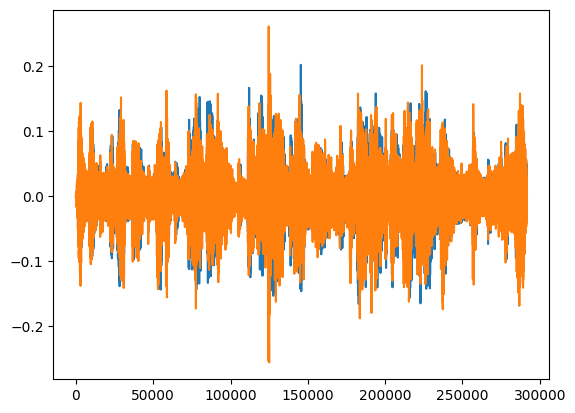

In [13]:
import matplotlib.pylab as plt

plt.plot(signal)

### Applying the NALR and Compressor components

We will now build the NALR filterbank according to the audiograms of the listener we have selected and apply the filter to the scene signal. This is done separately for the left and right ear (i.e., for each channel of the stereo scene signal).


In [14]:
import numpy as np

nalr_fir, _ = enhancer.build(listener["audiogram_levels_l"], listener["audiogram_cfs"])
out_l = enhancer.apply(nalr_fir, signal[:, 0])

nalr_fir, _ = enhancer.build(listener["audiogram_levels_r"], listener["audiogram_cfs"])
out_r = enhancer.apply(nalr_fir, signal[:, 1])

plt.plot(out_l)

TypeError: NALR.build() takes 2 positional arguments but 3 were given

Following this, slow AGC is applied and a clip detection pass is performed. A tanh function is applied to remove high frequency distortion components from cliipped samples and the files are converted back to 16-bit integer format for saving.

In [15]:
out_l, _, _ = compressor.process(out_l)
out_r, _, _ = compressor.process(out_r)

enhanced_audio = np.stack([out_l, out_r], axis=1)

plt.plot(enhanced_audio)

NameError: name 'out_l' is not defined

Finally, the signals are placed through a tanh function which provides a soft-clipping to handle any transient segments that have not been dealt with by the ACG.

The final signals are then converted back into 16-bit format.

In [16]:
n_clipped = np.sum(np.abs(enhanced_audio) > 1.0)
if n_clipped > 0:
    print(f"{n_clipped} samples clipped")
enhanced_audio = np.tanh(enhanced_audio)
np.clip(enhanced_audio, -1.0, 1.0, out=enhanced_audio)

plt.plot(enhanced_audio)

NameError: name 'enhanced_audio' is not defined

Note, processed signals will be submitted as 16-bit wav-file format, i.e. by first converting back to 16-bit integer format and then saving to file.

```python
signal_16 = (32768.0 * enhanced_audio).astype(np.int16)
```

The standard filename for the processed audio is constructed as

```python
filename = f"{scene['scene']}_{listener['name']}_HA-output.wav"
```

## Evaluating outputs using HASPI

---
Enhanced scores can now be evaluated using the HASPI speech intelligibility prediction metric and compared to the unenhanced audio.

HASPI scores are calculated using a 'better ear' approach where left and right signals are acalculated and the higher score used as the output.

The 'better ear' haspi function (`haspi_v2_be`) is imported from <code>clarity.evaluator.haspi</code>.



In [17]:
from clarity.evaluator.haspi import haspi_v2_be

HASPI is an intrusive metric and requires an uncorrupted reference signal. These are provided in the scenes audio data as files with the naming convention <code>SXXXX_target_CHX.wav</code>. CH1 is used as the reference transducer for this challenge. We load the file and convert to floating point as before. 

In [18]:
fs, reference = wavfile.read(
    os.path.join(cfg.path.scenes_folder, f"{scene_id}_target_CH1.wav")
)
reference = reference / 32768.0

We provide the function <code>haspi_v2_be</code> with the left and right references, the left and right signals, the sample rate and the audiogram information for the given listener. 

Below, we first compute the HASPI score for the unprocessed signal and then for the enhanced signal. We can compute the benefit of the processing by calculating the difference.

In [19]:
sii_unprocessed = haspi_v2_be(
    xl=reference[:, 0],
    xr=reference[:, 1],
    yl=signal[:, 0],
    yr=signal[:, 1],
    fs_signal=fs,
    audiogram_l=listener["audiogram_levels_l"],
    audiogram_r=listener["audiogram_levels_r"],
    audiogram_cfs=listener["audiogram_cfs"],
)

sii_enhanced = haspi_v2_be(
    xl=reference[:, 0],
    xr=reference[:, 1],
    yl=enhanced_audio[:, 0],
    yr=enhanced_audio[:, 1],
    fs_signal=fs,
    audiogram_l=listener["audiogram_levels_l"],
    audiogram_r=listener["audiogram_levels_r"],
    audiogram_cfs=listener["audiogram_cfs"],
)

print(f"Original audio HASPI score is {sii_unprocessed}")

print(f"Enhanced audio HASPI score is {sii_enhanced}")

print(f"Improvement from processing is {sii_enhanced - sii_unprocessed}")

TypeError: haspi_v2_be() got an unexpected keyword argument 'xl'

For the scene and listener we have selected the original HASPI score should be about `0.081` and the score after enhancement should be about `0.231`. Note, HASPI uses internal masking noise and because we have not set the random seed, scores may vary a little from run to run - the variation should not be more than `+-0.0005` and often much less. 

Note also that the 'enhanced' score is still very low - this is not surprising given that the processing is only amplying amplification and compression. There is no noise cancellation, no multichannel processing, etc, etc. The purpose of the enhancement challenge is to add these components in order to try and improve on this baseline.

Good luck!